### Purpose and description of this notebook 

This notebook is used to see what grid boxes overlap baileys ecoregions. These assigments will be used to select the meteorology for a given ecoregion where fire occurrence in being investigated. 
- Note on latitude extent, relevant for Marine division, which will be cut at the 50s parallel, in order to match the fire data, which also cuts data in this division to be for washington only, for the time being. 

In [1]:
from shapely.geometry import Polygon, Point
import geopandas
import numpy as np
import os
import matplotlib.pylab as plt

In [2]:
from cdo import *
cdo = Cdo()

In [3]:
# Load US ecoregions and plot the united states land mass together
eco_dir = os.path.join("..", "Data", "LandCover", "eco-us-shp")
eco_shp = geopandas.read_file(eco_dir)
print(type(eco_shp))
print(eco_shp.crs)

<class 'geopandas.geodataframe.GeoDataFrame'>
{'proj': 'laea', 'lat_0': 45, 'lon_0': -100, 'x_0': 0, 'y_0': 0, 'a': 6370997, 'b': 6370997, 'units': 'm', 'no_defs': True}


Reproject the ecoregion to a crs that will be common throughout this code. 

In [4]:
eco_reprojected = eco_shp.to_crs({'init': '+init=epsg:4326'})

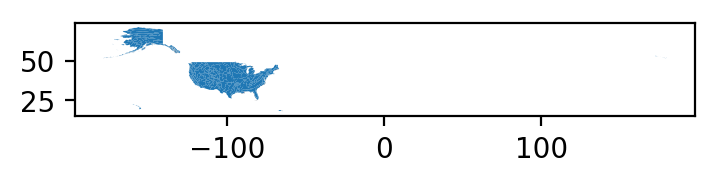

In [5]:
f, ax = plt.subplots(1, figsize=(4, 1.5), dpi=200)
eco_reprojected.plot(ax=ax)
plt.show()

Get a CMIP5 netcdf file so that we know the grid that needs to be masked with division overlaps. 

In [6]:
from netCDF4 import Dataset
cmip_dir = os.path.join('..','Data','CMIP5','r1i1p1_rcp_COMMON_GRID', 'pr_Amon_CanESM2_rcp85_r1i1p1_198301-210012.nc')
cmip = Dataset(cmip_dir,'r')
lat = cmip.variables['lat'][:]
lon = cmip.variables['lon'][:] - 180. # Will be reprojected using CDO
tas = cmip.variables['pr'][:]
cmip.close()

Get the width and heigh of grid boxes to build polygons from them with. 

In [7]:
dx = np.unique(np.diff(lon))
print(dx)
dy = np.unique(np.diff(lat))
print(dy)

[2.5]
[2.]


In [8]:
# Make polygons that describe the global grid
grid_polygons = []

for i in range(len(lon)) :
    for j in range(len(lat)) :
        
        x_center = lon[i]
        y_center = lat[j]
        
        # Make the four locations that describe a grid box as a polygon
        x0 = x_center - dx/2.
        x1 = x_center + dx/2.
        y0 = y_center - dy/2.
        y1 = y_center + dy/2.
        
        grid_box_poly = Polygon([[x0, y0], [x1, y0], [x1, y1], [x0, y1]])
        
        grid_polygons.append(grid_box_poly)


grid_geo = geopandas.GeoSeries(grid_polygons)

In [9]:
len(grid_polygons)

12960

In [10]:
# Make a GeoDataFrame
grid_geo_df = geopandas.GeoDataFrame({'geometry':grid_polygons, 'grid_ID': np.arange(len(grid_polygons))})
# CRS projection to assign to grid boxes when made into polygons. Matches that
# Assigned to the ecoregions plotted above. 
crs_to_assign = {'init': '+init=epsg:4326'}
grid_geo_df.crs = crs_to_assign

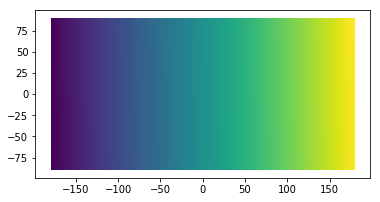

In [11]:
grid_geo_df.plot('grid_ID')

In [12]:
# Get world land mass file and set to the same crs 
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
world_df = world.to_crs(crs_to_assign)

<Figure size 600x400 with 0 Axes>

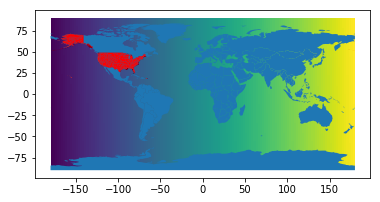

In [13]:
plt.figure(dpi=100)
base = grid_geo_df.plot('grid_ID')
world_df.plot(ax=base)
eco_reprojected.plot(ax=base, color='red')
plt.show()

In [14]:
# The grid_ID that show up in overlap are the ones I need to flag as overlapping land. 
overlap = geopandas.overlay(grid_geo_df, world_df, how='intersection')

In [15]:
overlap.columns

Index(['grid_ID', 'pop_est', 'continent', 'name', 'iso_a3', 'gdp_md_est',
       'geometry'],
      dtype='object')

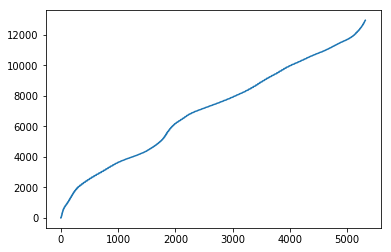

In [16]:
unique_overlapping_grid_IDs = np.unique(np.array(overlap.grid_ID.copy()))
plt.plot(np.sort(unique_overlapping_grid_IDs))

In [17]:
print(len(unique_overlapping_grid_IDs))
print(len(np.unique(unique_overlapping_grid_IDs)))

5322
5322


In [18]:
print(grid_geo_df.columns)
print(world_df.columns)

Index(['geometry', 'grid_ID'], dtype='object')
Index(['pop_est', 'continent', 'name', 'iso_a3', 'gdp_md_est', 'geometry'], dtype='object')


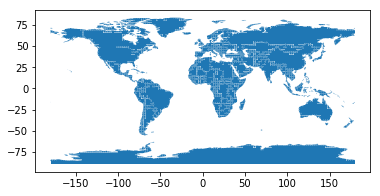

In [19]:
# Show where the world land data overlaps some part of the synthetic grid 
overlap.plot()

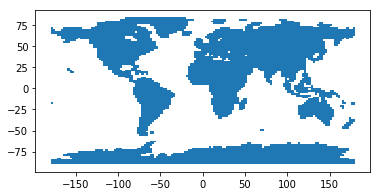

In [20]:
# Show what CMIP5 common grid cells overlap land. 
grid_geo_df.iloc[unique_overlapping_grid_IDs,:].plot()

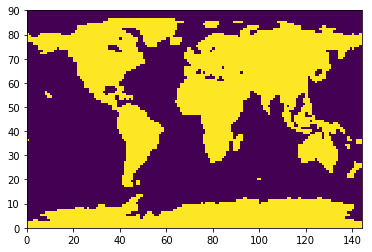

In [21]:
# Translate back to the original lat lon grid 
land_mask = np.zeros((len(lat), len(lon)), dtype=int)
count = 0
for i in range(len(lon)) :
    for j in range(len(lat)) :
        n_in_array = np.sum(count == unique_overlapping_grid_IDs)
        if n_in_array > 0 :
            land_mask[j,i] = 1
        count += 1
        
plt.pcolor(land_mask)

In [22]:
# Write this land mask as a netcdf file 
outputFile = os.path.join("..","Data","LandCover", "land_mask.nc")
outputFileCommonGrid = os.path.join("..","Data","LandCover", "common_grid_land_mask.nc")

ncFile = Dataset(outputFile, 'w', format='NETCDF4')
ncFile.description = 'Land mask according to netcdf grid box overlap with naturalearth_lowres grom geopandas'
ncFile.location = 'Global'
ncFile.createDimension('latitude', len(lat) )
ncFile.createDimension('longitude', len(lon) )

# Create data variables
VAR_ = ncFile.createVariable("land_mask", 'f4',('latitude','longitude'))
VAR_.units = "1=land, 0=not land"

# create lat variable
latitude_ = ncFile.createVariable('latitude', 'f4', ('latitude',))
latitude_.units = 'degrees_north'
latitude_.axis = "Y"

# create longitude variable
longitude_ = ncFile.createVariable('longitude', 'f4', ('longitude',))
longitude_.units = "degrees_east"
longitude_.long_name = "longitude"
longitude_.axis = "X"
#longitude_.lon_bnds = lon_bnds

# Write the actual data to these dimensions
VAR_[:]       = land_mask[:]
latitude_[:]  = np.array(lat)
longitude_[:] = np.array(lon)
ncFile.close()


common_grid_file = os.path.join("..","Data","LandCover",'COMMON_GRID.txt')
cdo.remapbil(common_grid_file, input=outputFile, output=outputFileCommonGrid, options="-b F64")

'../Data/LandCover/common_grid_land_mask.nc'

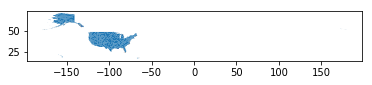

In [23]:
# Read in bailyes shapes
bailys_shp = eco_reprojected
bailys_shp.plot()

<Figure size 600x400 with 0 Axes>

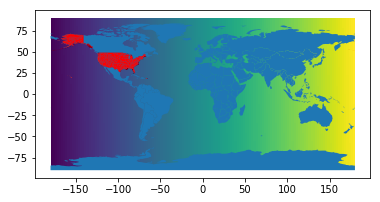

In [30]:
plt.figure(dpi=100)
base = grid_geo_df.plot('grid_ID')
world_df.plot(ax=base)
bailys_shp.plot(ax=base, color='red')
plt.show()

In [24]:
overlap = geopandas.overlay(grid_geo_df, bailys_shp, how='intersection')

In [25]:
overlap.columns

Index(['grid_ID', 'AREA', 'PERIMETER', 'ECO_US_', 'ECO_US_ID', 'ECOCODE',
       'DOMAIN', 'DIVISION', 'PROVINCE', 'SECTION', 'geometry'],
      dtype='object')

<Figure size 900x600 with 0 Axes>

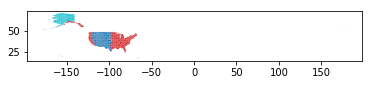

In [26]:
plt.figure(dpi=150)
ax=overlap.plot(column='DOMAIN')
#ax.set_xlim(left=-130, right=-65)
#ax.set_ylim(bottom=25, top=50)
plt.show()

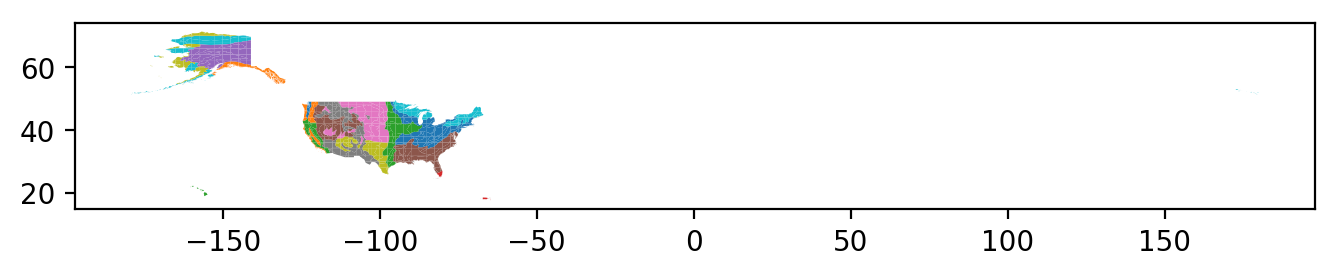

In [27]:
f, ax = plt.subplots(1, figsize=(8, 3), dpi=200)
ax1=overlap.plot(ax=ax, column='DIVISION')
#ax.set_xlim(left=-130, right=-65)
#ax.set_ylim(bottom=25, top=50)
plt.show()

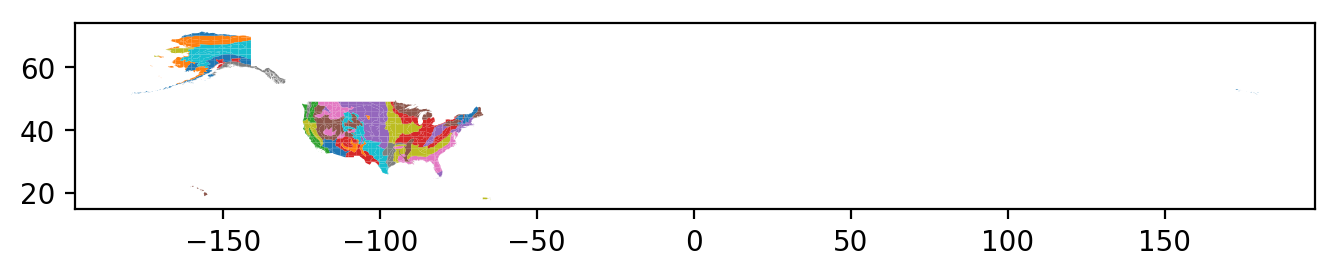

In [28]:
f, ax = plt.subplots(1, figsize=(8, 3), dpi=200)
ax1=overlap.plot(ax=ax, column='PROVINCE')
#ax.set_xlim(left=-130, right=-65)
#ax.set_ylim(bottom=25, top=50)
plt.show()

In [29]:
overlap

,grid_ID,AREA,PERIMETER,ECO_US_,ECO_US_ID,ECOCODE,DOMAIN,DIVISION,PROVINCE,SECTION,geometry
0,70,3.476444e+07,28823.936,172,330,M127B,POLAR DOMAIN,Tundra Regime Mountains,Aleutian Oceanic Meadow-Heath Province,Aleutian Islands Section,POLYGON ((-179.1244647910996 51.23042849958596...
1,70,3.063581e+07,32376.520,174,332,M127B,POLAR DOMAIN,Tundra Regime Mountains,Aleutian Oceanic Meadow-Heath Province,Aleutian Islands Section,POLYGON ((-178.8988488208616 51.34351033187876...
2,70,2.572425e+05,2076.692,173,331,M127B,POLAR DOMAIN,Tundra Regime Mountains,Aleutian Oceanic Meadow-Heath Province,Aleutian Islands Section,POLYGON ((-179.0075217978461 51.35685690992545...
3,70,1.262698e+06,4520.111,189,345,M127B,POLAR DOMAIN,Tundra Regime Mountains,Aleutian Oceanic Meadow-Heath Province,Aleutian Islands Section,POLYGON ((-178.2651666150719 51.48188063368989...
4,70,1.454366e+07,22864.043,171,329,M127B,POLAR DOMAIN,Tundra Regime Mountains,Aleutian Oceanic Meadow-Heath Province,Aleutian Islands Section,POLYGON ((-178.7911385171696 51.54583912306455...
5,70,1.982020e+06,7019.317,166,324,M127B,POLAR DOMAIN,Tundra Regime Mountains,Aleutian Oceanic Meadow-Heath Province,Aleutian Islands Section,POLYGON ((-179.0264405836872 51.57823684882069...
6,70,3.908319e+06,10204.708,177,335,M127B,POLAR DOMAIN,Tundra Regime Mountains,Aleutian Oceanic Meadow-Heath Province,Aleutian Islands Section,POLYGON ((-178.5836462072571 51.58622849366728...
7,70,9.079304e+06,15467.438,176,334,M127B,POLAR DOMAIN,Tundra Regime Mountains,Aleutian Oceanic Meadow-Heath Province,Aleutian Islands Section,POLYGON ((-178.6538993612175 51.59302781743194...
8,70,2.018659e+05,1917.632,194,350,M127B,POLAR DOMAIN,Tundra Regime Mountains,Aleutian Oceanic Meadow-Heath Province,Aleutian Islands Section,POLYGON ((-177.6664429626198 51.65683399404497...
9,70,5.363755e+08,184377.040,178,17,M127B,POLAR DOMAIN,Tundra Regime Mountains,Aleutian Oceanic Meadow-Heath Province,Aleutian Islands Section,POLYGON ((-178.0786870970876 51.66576161637781...


In [31]:
unique_divisions = np.unique(overlap.DIVISION)

In [44]:
# Store masks that indicate if a grid cell overlaps with a given division
division_dictionary = {}

for division in unique_divisions : 
    
    print("Masking " + division)
    
    # Translate back to the original lat lon grid for a single land cover type
    land_cover_area = np.zeros((len(lat), len(lon)), dtype=int)
    grid_index = 0
    for i in range(len(lon)) :
        for j in range(len(lat)) :

            # Where in over does this grid_index exist?
            in_array = grid_index == np.array(overlap.grid_ID)
            # What of those are the division of interest? 
            division_mask = division == np.array(overlap.DIVISION)        
            m = in_array & division_mask

            if np.sum(m) > 0 :
                land_cover_area[j,i] = 1 #np.sum(overlap.loc[m,'AREA'])

            grid_index += 1
            
    # Assign these values, store in the dictionary
    division_dictionary[division] = land_cover_area

Masking Hot Continental Division
Masking Hot Continental Regime Mountains
Masking Marine Division
Masking Marine Regime Mountains
Masking Mediterranean Division
Masking Mediterranean Regime Mountains
Masking Prairie Division
Masking Rainforest Regime Mountains
Masking Savanna Division
Masking Savanna Regime Mountains
Masking Subarctic Division
Masking Subarctic Regime Mountains
Masking Subtropical Division
Masking Subtropical Regime Mountains
Masking Temperate Desert Division
Masking Temperate Desert Regime Mountains
Masking Temperate Steppe Division
Masking Temperate Steppe Regime Mountains
Masking Tropical/Subtropical Desert Division
Masking Tropical/Subtropical Regime Mountains
Masking Tropical/Subtropical Steppe Division
Masking Tundra Division
Masking Tundra Regime Mountains
Masking Warm Continental Division
Masking Warm Continental Regime Mountains


### Manually edit out the high latitude (above 50 degrees north) part of the "Marine Regime Mountains" division in order to be consistent with the burn area data. 

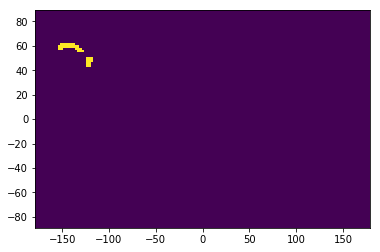

In [45]:
X, Y = np.meshgrid(lon, lat)
plt.pcolor(X,Y,division_dictionary['Marine Regime Mountains'])

Without Alaska

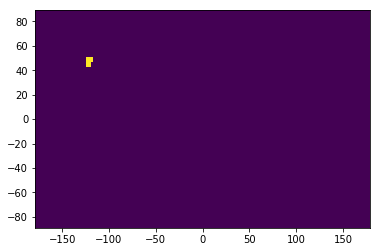

In [46]:
division_dictionary['Marine Regime Mountains'][np.where(lat > 51.)[0], :] = 0
plt.pcolor(X, Y, division_dictionary['Marine Regime Mountains'])

### Create a custom mask that corrosponds to a combination of masks in the region. A "wester_US" mask

In [47]:
# Western US divisions to be included in this analysis 
western_divisions = ["Temperate Steppe Regime Mountains", 
                     "Marine Regime Mountains", 
                     'Marine Division', # No burn area! So will exclude
                     "Mediterranean Regime Mountains", # includes southern coastal Alaska sections
                     "Mediterranean Division",
                     'Temperate Desert Division',
                     "Tropical/Subtropical Steppe Division",
                     'Tropical/Subtropical Desert Division',
                     'Tropical/Subtropical Regime Mountains',
                     'Temperate Desert Regime Mountains',
                    ]

# Create an array to save the count for regions overlapping the US
western_US_count = np.zeros((len(lat), len(lon)), dtype=int)

for div in western_divisions : 
    western_US_count += division_dictionary[div]    

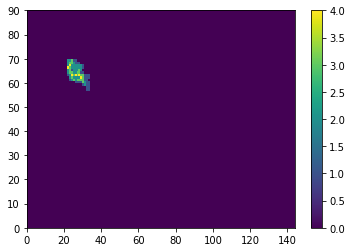

In [48]:
plt.pcolor(western_US_count)
plt.colorbar()

In [49]:
# Add the western US region to the dictionary
division_dictionary["western_US"] = western_US_count

In [50]:
division_dictionary.keys()

dict_keys(['Hot Continental Division', 'Hot Continental Regime Mountains', 'Marine Division', 'Marine Regime Mountains', 'Mediterranean Division', 'Mediterranean Regime Mountains', 'Prairie Division', 'Rainforest Regime Mountains', 'Savanna Division', 'Savanna Regime Mountains', 'Subarctic Division', 'Subarctic Regime Mountains', 'Subtropical Division', 'Subtropical Regime Mountains', 'Temperate Desert Division', 'Temperate Desert Regime Mountains', 'Temperate Steppe Division', 'Temperate Steppe Regime Mountains', 'Tropical/Subtropical Desert Division', 'Tropical/Subtropical Regime Mountains', 'Tropical/Subtropical Steppe Division', 'Tundra Division', 'Tundra Regime Mountains', 'Warm Continental Division', 'Warm Continental Regime Mountains', 'western_US'])

In [54]:
# Write this land mask as a netcdf file 
outputFile = os.path.join("..","Data","LandCover", "bailys_division_masks.nc")
outputFileCommonGrid = os.path.join("..","Data","LandCover", "bailys_division_masks_common_grid.nc")

ncFile = Dataset(outputFile, 'w', format='NETCDF4')
ncFile.description = 'Bailys Division masks'
ncFile.location = 'Global'
ncFile.createDimension('latitude', len(lat) )
ncFile.createDimension('longitude', len(lon) )

# create lat variable
latitude_ = ncFile.createVariable('latitude', 'f4', ('latitude',))
latitude_.units = 'degrees_north'
latitude_.axis = "Y"

# create longitude variable
longitude_ = ncFile.createVariable('longitude', 'f4', ('longitude',))
longitude_.units = "degrees_east"
longitude_.long_name = "longitude"
longitude_.axis = "X"
#longitude_.lon_bnds = lon_bnds

# Create data variables
for key in division_dictionary.keys() :
    key_name = key.replace("/", " ")
    print(key_name)
    VAR_ = ncFile.createVariable(key_name, 'f4',('latitude','longitude'))
    VAR_.units = "1=in_region, 0=outside_region"
    VAR_[:]    = division_dictionary[key]

latitude_[:]  = np.array(lat)
longitude_[:] = np.array(lon)
ncFile.close()

Hot Continental Division
Hot Continental Regime Mountains
Marine Division
Marine Regime Mountains
Mediterranean Division
Mediterranean Regime Mountains
Prairie Division
Rainforest Regime Mountains
Savanna Division
Savanna Regime Mountains
Subarctic Division
Subarctic Regime Mountains
Subtropical Division
Subtropical Regime Mountains
Temperate Desert Division
Temperate Desert Regime Mountains
Temperate Steppe Division
Temperate Steppe Regime Mountains
Tropical Subtropical Desert Division
Tropical Subtropical Regime Mountains
Tropical Subtropical Steppe Division
Tundra Division
Tundra Regime Mountains
Warm Continental Division
Warm Continental Regime Mountains
western_US


In [52]:
# And use cdo to make a common grid version 
import cdo as cdo
cdo = cdo.Cdo()

In [55]:
common_grid_file = os.path.join("..","Data","LandCover",'COMMON_GRID.txt')
cdo.remapbil(common_grid_file, input=outputFile, output=outputFileCommonGrid, options="-b F64")

'../Data/LandCover/bailys_division_masks_common_grid.nc'